# Intermediate Machine Learning

In this module, the focus will be on the following:

- design pipelines to improve the quality of your machine learning code,
- use advanced techniques for model validation (cross-validation),
- build state-of-the-art models that are widely used to win Kaggle competitions (XGBoost), and
- avoid common and important data science mistakes (leakage).



## Pipelines

Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Main benefits of using pipeline are :
- Cleaner Code: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
- Fewer Bugs: There are fewer opportunities to misapply a step or forget a preprocessing step.
- Easier to Productionize: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.

The full pipeline can be constructed in three steps:
### **Step 1**: **Define Preprocessing Steps**:
    - imputes missing values in numerical data, and
    - imputes missing values and applies a one-hot encoding to categorical data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Step 2: Define the Model:
Next, we define a `random forest model` with the familiar `RandomForestRegressor` class.

In [3]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

### Step 3: Create and Evaluate the Pipeline
- Finally, we use the Pipeline class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:
- With the pipeline, we preprocess the training data and fit the model in a single line of code. (In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)
- With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the pipeline automatically preprocesses the features before generating predictions. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [4]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)
                            ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


## Cross Validation

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.
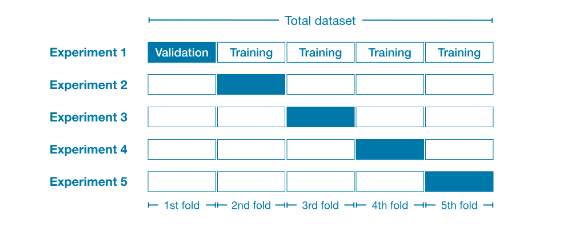

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

- For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
- For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import pandas as pd

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))])



# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


In [6]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277707.3795913405


Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code.

## XGBoost

